In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
import json
import pprint

In [2]:
def print_df(df_mlp, df_sa, verbose=True):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    if verbose:
        display(df_mlp[cols])
        display(df_mlp[layer_track_cols].sum() * depth)
        display(df_sa[cols])
        display(df_sa[layer_track_cols].sum() * depth)
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {}'.format(t_itr))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    
    param_count = ((df_mlp['weights_mem'].sum() + df_sa['weights_mem'].sum()) * depth) / system['element_size']
    print('mem consumed = {}'.format(mem))
    print('num parameters = {}B'.format(param_count/1E9))

In [3]:
### model
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3_xl = {'l': 2048, 'e': 2048, 'h': 16, 'depth': 24}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128}
gpt3_3T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128*3}
vit_era5 = {'l': 64800*4, 'e': 4096, 'h': 32, 'depth': 32}

In [4]:
model = gpt3_1T
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

with open('systems/config-B200.json', 'r') as file:
    system = json.load(file)

system['nvlink_size'] = 2    
m1 = 1
t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
df_mlp = mlp_1d(b, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
df_sa = sa_1d(b, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)
print_df(df_mlp, df_sa, verbose=True)


model: batch size = 1, seq length = 2048, embed = 25600, attention heads = 160, depth = 128


,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,fc1,5.242880,5.242880,10.737209,0.104858,0,reducescatter,21.472163,0,reducescatter,0.004315,0,0.004315,0.000000,5.985445,0.008609,0,0.008609,0.000000,5.970948,0.012924
1,fc1-bias,0.000205,0.000205,0.000210,0.000000,0,none,0.000210,0,none,0.000052,0,0.000021,0.000032,0.393077,0.000052,0,0.000021,0.000032,0.393077,0.000105
2,act1,0.000000,0.000000,0.001678,0.419430,0,none,0.002726,0,none,0.000105,0,0.000025,0.000080,0.237933,0.000157,0,0.000028,0.000129,0.178287,0.000262
3,dpr1,0.000000,0.000000,0.000210,0.209715,0,none,0.000210,0,none,0.000131,0,0.000021,0.000110,0.157308,0.000131,0,0.000021,0.000110,0.157308,0.000262
4,fc2,5.242880,5.242880,10.737366,0.419430,0,reducescatter,21.472005,0,reducescatter,0.004315,0,0.004315,0.000000,5.985532,0.008609,0,0.008609,0.000000,5.970904,0.012924
5,fc2-bias,0.000051,0.000051,0.000052,0.000000,0,none,0.000052,0,none,0.000020,0,0.000020,0.000000,1.536928,0.000020,0,0.000020,0.000000,1.536928,0.000040
6,dpr2,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,0.000033,0,0.000020,0.000013,0.615071,0.000033,0,0.000020,0.000013,0.615071,0.000066
7,ln1,0.000102,0.000102,0.000472,0.104858,0,allgather,0.000629,0,reducescatter,0.000026,0,0.000021,0.000005,0.815607,0.000066,0,0.000022,0.000044,0.333429,0.000092


activation_buffer     167.772160
weights_mem          1342.223155
weights_grad_mem     1342.223155
flops_fwd            2749.087770
flops_bwd            5497.350100
t_fwd                   1.151663
t_fwd_comm              0.000000
t_bwd                   2.262650
t_bwd_comm              0.000000
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,t_fwd_comp,t_fwd_mem,intensity_fwd,t_bwd,t_bwd_comm,t_bwd_comp,t_bwd_mem,intensity_bwd,t
0,qkv,3.932160,3.932160,8.052906,0.104858,0,reducescatter,16.104109,0,reducescatter,0.003241,0,0.003241,0.000000,5.958580,0.006462,0,0.006462,0.000000,5.939570,0.009703
1,fusedla,0.000000,0.000000,0.448567,0.420741,0,none,1.116779,0,none,0.000199,0,0.000199,0.000000,3.797830,0.000467,0,0.000467,0.000000,4.443964,0.000666
2,vproj,1.310720,1.310720,2.684302,0.104858,0,reducescatter,5.368001,0,reducescatter,0.001094,0,0.001094,0.000000,5.754778,0.002167,0,0.002167,0.000000,5.701527,0.003261
3,vproj-bias,0.000051,0.000051,0.000052,0.000000,0,none,0.000052,0,none,0.000020,0,0.000020,0.000000,1.536928,0.000020,0,0.000020,0.000000,1.536928,0.000040
4,dpr_v,0.000000,0.000000,0.000052,0.052429,0,none,0.000052,0,none,0.000033,0,0.000020,0.000013,0.615071,0.000033,0,0.000020,0.000013,0.615071,0.000066
5,ln2,0.000102,0.000102,0.000472,0.104858,0,allgather,0.000629,0,reducescatter,0.000026,0,0.000021,0.000005,0.815607,0.000066,0,0.000022,0.000044,0.333429,0.000092


activation_buffer     100.831068
weights_mem           671.108301
weights_grad_mem      671.108301
flops_fwd            1431.853077
flops_bwd            2891.471742
t_fwd                   0.590523
t_fwd_comm              0.000000
t_bwd                   1.179395
t_bwd_comm              0.000000
dtype: float64

time for 1 itr = 5.184230932525237
mem consumed = 16375.254876160001
num parameters = 1006.665728B


model: batch size = 1, seq length = 2048, embed = 25600, attention heads = 160, depth = 128
[4096 4096 4096 4096 4096 4096 4096 4096]
4 2 1
4 2 1
8 1 1
8 1 1
8 1 1
8 1 1
8 1 1
8 1 1


/tmp/ipykernel_1572121/2867283171.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0,20,40,60,80,100], fontsize=14)


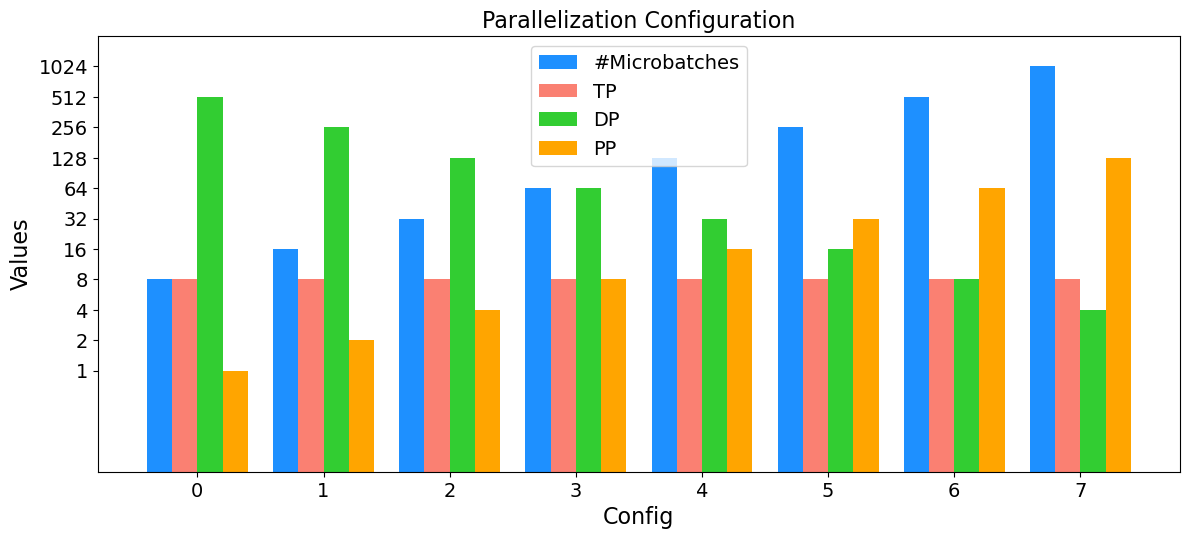

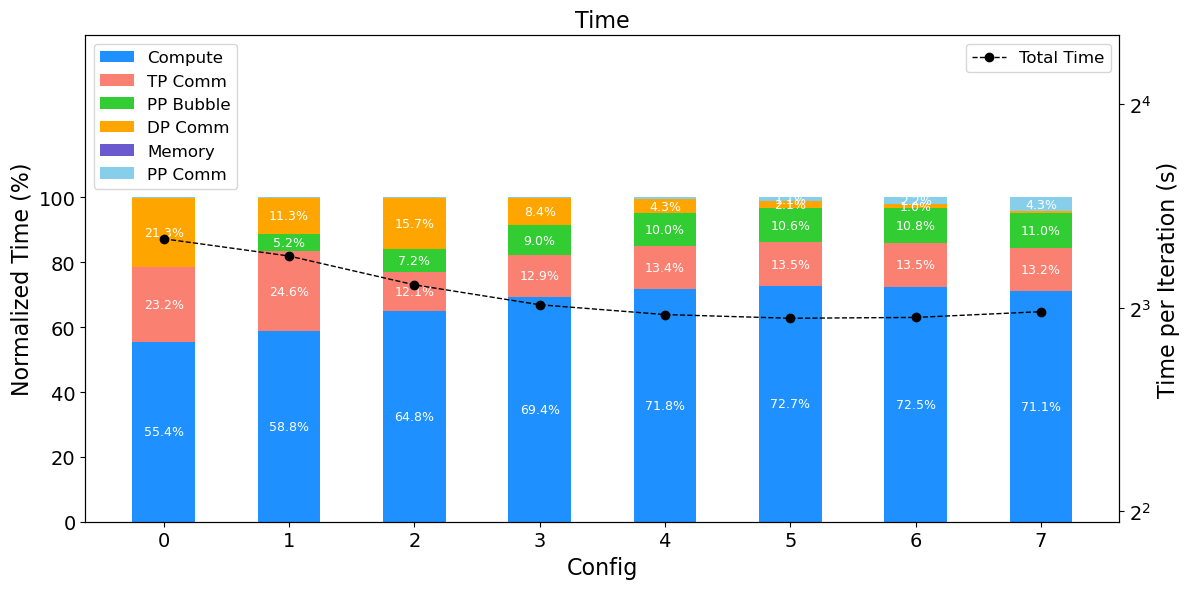

In [5]:
model = gpt3_1T
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))


with open('systems/config-B200.json', 'r') as file:
    system = json.load(file)
nvs = 8
system['nvlink_size'] = nvs
global_batch_size = 4096

total_gpus = 4096
N = 8
n_values = np.arange(0,N)
m_values =  [1] * N

tp_values = np.array([8] * N)
pp_values = 2**np.arange(0,N) #[1,2,4,8,16,32,64,128]
dp_values = (total_gpus / (pp_values * tp_values)).astype(int)

# tp_values = 2**np.arange(0,N)
# pp_values = np.array([32] * N)
# dp_values = (total_gpus / (pp_values * tp_values)).astype(int)
# tp_values = [1,2,4,8,16,32,64,128]
# dp_values = np.array([32] * N)
# pp_values = (total_gpus / (dp_values * tp_values)).astype(int)

print(dp_values * pp_values * tp_values)

time_part1 = []
time_part2 = []
time_part3 = []
time_part4 = []
time_part5 = []
time_part6 = []
nm_values = []
for mbs,tp,pp,dp in zip(m_values,tp_values,pp_values,dp_values):
    best_time = np.inf
    stats = None
    # print(mbs,tp,pp,dp)
    for nv1, nv2, nv3 in nv_candidates_1d(tp, dp, pp, nvs):
        # print(nv1,nv2,nv3)
        nm = (global_batch_size / dp) / mbs
        m1 = tp
        # t1 = m1 if m1 <= system['nvlink_size'] else system['nvlink_size']
        t1 = nv1
        t_dp = nv2
        t_pp = nv3
        df_mlp = mlp_1d(mbs, l, e, f, parallelism={'m': m1}, topology={'t': t1}, system=system)
        df_sa = sa_1d(mbs, l, e, h, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True, system=system)
        df_dp = dataparallel(modules=[df_mlp, df_sa], depth=(depth//pp), dp=dp, t_dp=t_dp, overlap=True, system=system)

        # pp comms
        # only communicate the last layer activations = first layer's (ln1) input buffer
        p2p_comm_vol = float(df_mlp.loc[df_mlp['name'] == 'ln1']['activation_buffer'])
        df_pp = pipelineparallel(modules=[df_mlp, df_sa], number_micro_batches=nm, comm_vol=p2p_comm_vol, pp=pp, t_pp=t_pp, overlap=False, system=system)

        # total time
        (t, mem), stats_running = totals(df_mlp, df_sa, df_dp, df_pp, depth, pp=pp, dp=dp, number_micro_batches=nm)
        stats_running['nv_tp'] = t1
        stats_running['nv_dp'] = t_dp
        stats_running['nv_pp'] = t_pp
        # print(t, stats_running['nv_tp'], stats_running['nv_dp'], stats_running['nv_pp'])
        if t < best_time:
            stats = stats_running
            best_time = t
    # print('###')
            
    print(stats['nv_tp'], stats['nv_dp'], stats['nv_pp'])
    time_part1.append(stats['t_comp'])
    time_part2.append(stats['t_comm'])
    time_part3.append(stats['t_bubble'])
    time_part4.append(stats['t_dp_comm'])
    time_part5.append(stats['t_mem_exposed'])
    time_part6.append(stats['t_pp_comm'])
    
    nm_values.append(nm)

    
m_values = nm_values # swap to #microbatches

time_part1 = np.array(time_part1)
time_part2 = np.array(time_part2)
time_part3 = np.array(time_part3)
time_part4 = np.array(time_part4)
time_part5 = np.array(time_part5)
time_part6 = np.array(time_part6)
time_total = time_part1 + time_part2 + time_part3 + time_part4 + time_part5 + time_part6
# Create the plot
plt.figure(figsize=(12, 10))

# First plot: m, tp, dp, pp as a function of n
plt.subplot(2, 1, 1)
bar_width = 0.2
log_n_values = np.array(n_values)

plt.bar(log_n_values - 1.5 * bar_width, m_values, bar_width, label='#Microbatches', color='dodgerblue')
plt.bar(log_n_values - 0.5 * bar_width, tp_values, bar_width, label='TP', color='salmon')
plt.bar(log_n_values + 0.5 * bar_width, dp_values, bar_width, label='DP', color='limegreen')
plt.bar(log_n_values + 1.5 * bar_width, pp_values, bar_width, label='PP', color='orange')

plt.xlabel('Config', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.title('Parallelization Configuration', fontsize=16)
plt.xticks(log_n_values, n_values, fontsize=14)
plt.yscale('log', base=2)
top = max(max(m_values), max(tp_values), max(dp_values), max(pp_values))
top2 = int(np.ceil(np.log2(top)))+1
plt.ylim([0.1, top * 2])
plt.yticks([2**i for i in range(0, top2)], [2**i for i in range(0, top2)], fontsize=14)
# plt.xlim([np.log2(n_values[0]) - 1, np.log2(n_values[-1]) + 1])
plt.legend(fontsize=14)
plt.tight_layout()

# Second plot: Time vs n as a stacked bar plot with percentages and total time line
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.5

# Normalize the time parts
time_parts = np.array([time_part1, time_part2, time_part3, time_part4, time_part5, time_part6])
time_parts_normalized = time_parts / time_total[:, np.newaxis].T * 100

# Create the stacked bar plot
colors = ['dodgerblue', 'salmon', 'limegreen', 'orange', 'slateblue', 'skyblue']
labels = ['Compute', 'TP Comm', 'PP Bubble', 'DP Comm', 'Memory', 'PP Comm']
bottom = np.zeros(len(n_values))

for i, (height, color, label) in enumerate(zip(time_parts_normalized, colors, labels)):
    p = ax1.bar(log_n_values, height, bottom=bottom, label=label, color=color, width=bar_width)
    bottom += height

    # Add percentage text
    for j, h in enumerate(height):
        if h > 1:  # Only show percentage if it's greater than 1%
            ax1.text(log_n_values[j], bottom[j] - h/2, f'{h:.1f}%', ha='center', va='center', color='white', fontsize=9)

ax1.set_xlabel('Config', fontsize=16)
ax1.set_ylabel('Normalized Time (%)', fontsize=16)
ax1.set_title('Time', fontsize=16)
ax1.set_xticks(log_n_values)
ax1.set_xticklabels(n_values, fontsize=14)
ax1.set_yticklabels([0,20,40,60,80,100], fontsize=14)
ax1.set_yticks([0,20,40,60,80,100])
# ax1.set_xlim([np.log2(n_values[0]) - 1, np.log2(n_values[-1]) + 1])
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(axis='y', labelsize=14)

# Adjust y-axis to make smaller bars more visible
ax1.set_ylim(0, 150)  # Set to slightly over 100% to give some headroom

# Add the total time line plot on the right y-axis
ax2 = ax1.twinx()
ax2.plot(log_n_values, time_total, color='black', linewidth=1, linestyle='--', marker='o', label='Total Time')
ax2.set_ylabel('Time per Iteration (s)', fontsize=16, color='black')
ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
ax2.set_yscale('log', base=2)

# Set y-axis limits for total time
ax2.set_ylim(min(time_total) / 2, max(time_total) * 2)

# Add legend for the line plot
lines, labels = ax2.get_legend_handles_labels()
ax1.legend(fontsize=12, loc='upper left')
ax2.legend(lines, labels, fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()